In [308]:
### Data Manipulation and Analysis
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical operations and array handling

### Data Visualization
import matplotlib.pyplot as plt  # Data visualization and plotting

### Statistical Functions and Tests
from scipy.stats import linregress, t, kruskal, binomtest, boxcox  # Statistical functions and tests
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelation and partial autocorrelation plots

### Machine Learning Metrics
from sklearn.metrics import mean_squared_error, make_scorer  # Machine learning metrics for model evaluation

### Time Series Analysis and Models
import statsmodels.api as sm  # Various statistical models and tests
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMAX model for time series forecasting
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

### Machine Learning Models
from sklearn.neural_network import MLPRegressor  # Neural network models, specifically MLPRegressor

### Utility Functions
import itertools  # Utility functions for efficient looping
import warnings # Supress Warnings


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [309]:
# Function for the Cox-Stuart test
def cox_stuart_test(data):
    n = len(data)
    half = n // 2
    if n % 2 != 0:  # if the number of observations is odd, remove the last point to pair up
        half = (n - 1) // 2
    first_half = data[:half]
    second_half = data[-half:]
    diffs = np.sign(second_half - first_half)
    S = np.sum(diffs == -1)
    T = np.sum(diffs == 1)
    return S, T, half

# Function for inverse Box-Cox transformation
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)
    
# Function to evaluate SARIMA model
def evaluate_sarima_model(train, test, arima_order, seasonal_order, lmbda, seed):
    np.random.seed(seed)  # Set the random seed for reproducibility
    model = SARIMAX(train, order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    predictions = model_fit.forecast(steps=len(test))
    predictions_inv = inv_boxcox(predictions, lmbda)
    test_inv = inv_boxcox(test, lmbda)
    rmse = np.sqrt(mean_squared_error(test_inv, predictions_inv))
    aic = model_fit.aic
    return rmse, aic

# Create function to prepare the dataset for MLP
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Define the evaluation metric (RMSE)
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [310]:
# Read the DataFrame from the CSV file
df = pd.read_csv('../data/month_energy_dataset.csv')

# Create a date column by combining year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter the DataFrame for the desired date range
df = df.loc['2007-01':'2021-03']

# Convert the generation values to thousands
df['generation_value'] = df['val_geracao'] / 1000

df

,year,month,val_geracao,generation_value
date,,,,
2007-01-01,2007,1,44518.780,44.518780
2007-02-01,2007,2,36306.070,36.306070
2007-03-01,2007,3,28729.610,28.729610
2007-04-01,2007,4,37405.240,37.405240
2007-05-01,2007,5,39726.350,39.726350
...,...,...,...,...
2020-11-01,2020,11,4998341.191,4998.341191
2020-12-01,2020,12,5443760.484,5443.760484
2021-01-01,2021,1,5397353.255,5397.353255


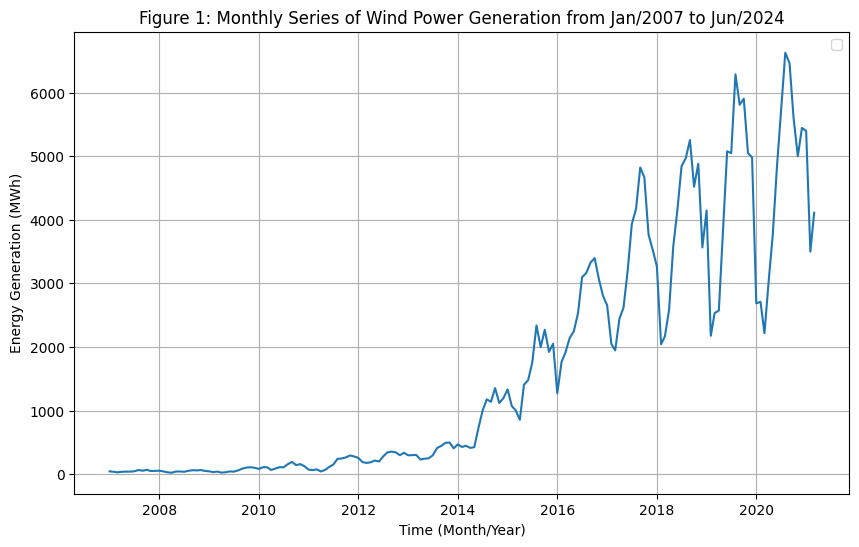

In [311]:
# Plot the training and test sets
plt.figure(figsize=(10, 6))
plt.plot(df['generation_value'])
plt.title('Figure 1: Monthly Series of Wind Power Generation from Jan/2007 to Jun/2024')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

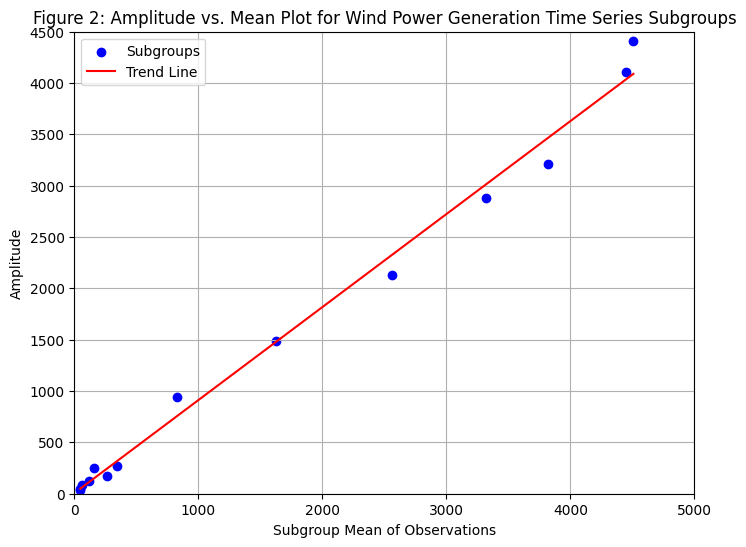

Slope:  0.9058055049016748
P-value: 8.282263763703668e-14


In [312]:
# Divide the time series into subgroups of size N (e.g., 12 months)
N = 12  # Subgroup size (e.g., 12 for annual subgroups)
subgroups = [df['generation_value'][i:i + N] for i in range(0, len(df), N)]

# Calculate the mean and amplitude for each subgroup
mean_values = [group.mean() for group in subgroups if len(group) == N]
amplitude_values = [group.max() - group.min() for group in subgroups if len(group) == N]

# Linear regression for the trend line
slope, intercept, r_value, p_value, std_err = linregress(mean_values, amplitude_values)
line = [slope * xi + intercept for xi in mean_values]

# Plot the amplitude versus mean graph
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, amplitude_values, color='blue', label='Subgroups')
plt.plot(mean_values, line, color='red', label='Trend Line')

# Add titles and labels
plt.title('Figure 2: Amplitude vs. Mean Plot for Wind Power Generation Time Series Subgroups')
plt.xlabel('Subgroup Mean of Observations')
plt.ylabel('Amplitude')

# Adjust axis limits to match the original graph
plt.xlim(0, 5000)
plt.ylim(0, 4500)

# Add grid
plt.grid(True)

# Show legend
plt.legend()

# Display the graph
plt.show()

# Calculate the t-value and the associated p-value
t_value = slope / std_err
d_f = len(mean_values) - 2  # degrees of freedom
p_value = 2 * (1 - t.cdf(np.abs(t_value), d_f))

print('Slope: ', slope)
print(f'P-value: {p_value}')


Estimated lambda value: 0.07207642475514588


<Figure size 1000x600 with 0 Axes>

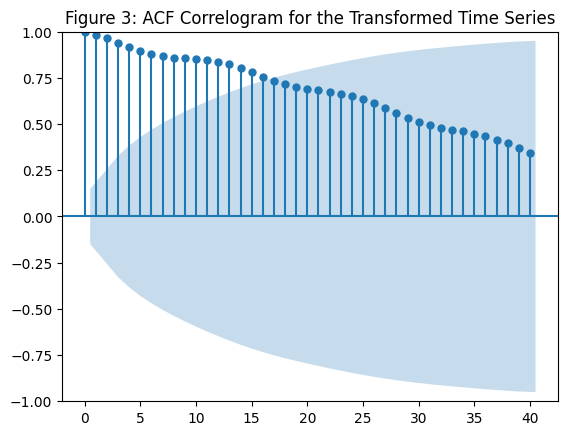

<Figure size 1000x600 with 0 Axes>

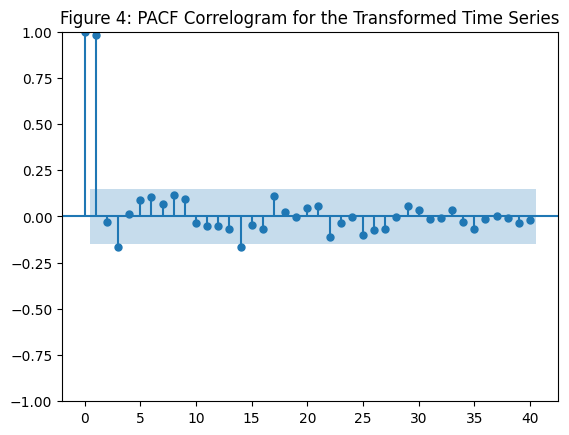

In [313]:
# Apply Box-Cox transformation
df['generation_value_boxcox'], fitted_lambda = boxcox(df['generation_value'])
print(f'Estimated lambda value: {fitted_lambda}')

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 3: ACF Correlogram for the Transformed Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 4: PACF Correlogram for the Transformed Time Series')
plt.show()

In [314]:
# Cox-Stuart test for trend
S, T, half = cox_stuart_test(df['generation_value_boxcox'])
p_value_cox_stuart = binomtest(min(S, T), n=half, p=0.5).pvalue  # Binomial test to calculate the p-value
print(f'Cox-Stuart Test: S={S}, T={T}, p-value={p_value_cox_stuart}')

Cox-Stuart Test: S=0, T=0, p-value=5.169878828456423e-26


In [315]:
# Kruskal-Wallis test for seasonality
# Group data by month to check for seasonality
df['month'] = df.index.month
seasonal_groups = [df[df['month'] == month]['generation_value_boxcox'] for month in range(1, 13)]
H, p_value_kruskal = kruskal(*seasonal_groups)
print(f'Kruskal-Wallis Test: H={H}, p-value={p_value_kruskal}')

Kruskal-Wallis Test: H=6.859569466301309, p-value=0.8103391243295635


<Figure size 1000x600 with 0 Axes>

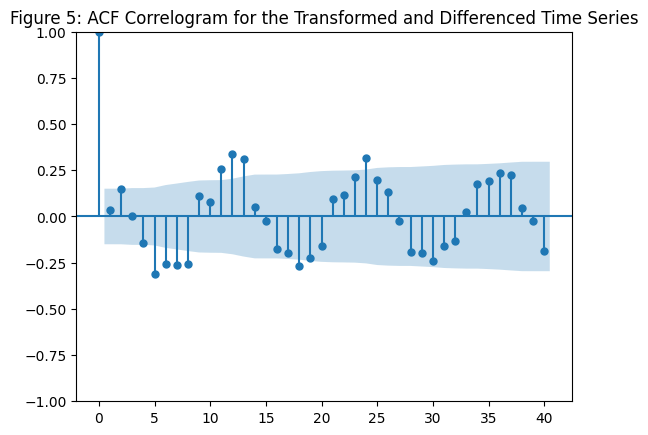

<Figure size 1000x600 with 0 Axes>

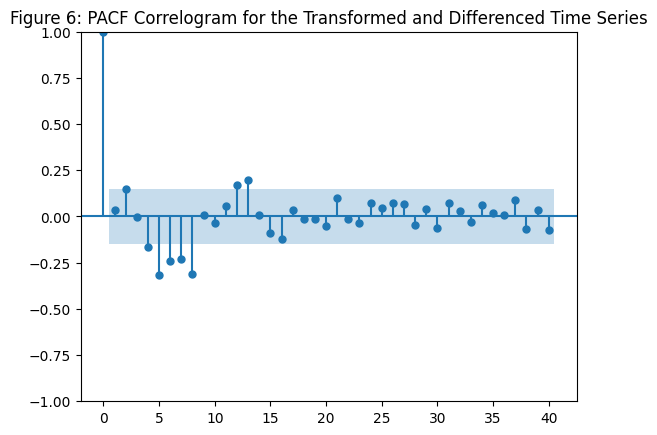

In [316]:
# Apply first-order differencing
df['generation_value_boxcox_diff'] = df['generation_value_boxcox'].diff().dropna()

# Remove N/A values
df = df.dropna(subset=['generation_value_boxcox_diff'])

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 5: ACF Correlogram for the Transformed and Differenced Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 6: PACF Correlogram for the Transformed and Differenced Time Series')
plt.show()

## SARIMA Model

In [317]:
df

,year,month,val_geracao,generation_value,generation_value_boxcox,generation_value_boxcox_diff
date,,,,,,
2007-02-01,2007,2,36306.070,36.306070,4.099828,-0.266138
2007-03-01,2007,3,28729.610,28.729610,3.799150,-0.300677
2007-04-01,2007,4,37405.240,37.405240,4.138509,0.339358
2007-05-01,2007,5,39726.350,39.726350,4.216841,0.078332
2007-06-01,2007,6,39830.250,39.830250,4.220247,0.003406
...,...,...,...,...,...,...
2020-11-01,2020,11,4998341.191,4998.341191,11.759161,-0.208701
2020-12-01,2020,12,5443760.484,5443.760484,11.917362,0.158201
2021-01-01,2021,1,5397353.255,5397.353255,11.901452,-0.015910


In [318]:
# Parameters
p_values = [2, 4, 5, 6, 7, 8]
d = 1
q_values = [2, 4, 5, 6, 7, 8]
P = 1
D = 0
Q = 2
S = 12  # Seasonal order
seed = 42  # Random seed for reproducibility

# Split the data into train and test sets
train = df['2007-01':'2019-12']
test = df['2020-01':'2021-03']

# Store results
results = []

# Suppress specific warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

# Generate all combinations of (p,d,q) and run SARIMA models
for p, q in itertools.product(p_values, q_values):
    if q == S:  # Avoid overlap of seasonal and non-seasonal lags
        continue
    arima_order = (p, d, q)
    seasonal_order = (P, D, Q, S)
    try:
        rmse, aic = evaluate_sarima_model(train['generation_value_boxcox'], test['generation_value_boxcox'], arima_order, seasonal_order, fitted_lambda, seed)
        results.append((arima_order, seasonal_order, rmse, aic))
    except Exception as e:
        results.append((arima_order, seasonal_order, None, None))
        print(f'Error with ARIMA order {arima_order} and seasonal order {seasonal_order}: {e}')

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['ARIMA Order', 'Seasonal Order', 'RMSE', 'AIC'])
results_df = results_df.sort_values(by='RMSE').dropna()

# Display the best models
results_df.head()

,ARIMA Order,Seasonal Order,RMSE,AIC
33,"(8, 1, 6)","(1, 0, 2, 12)",712.900725,66.484164
28,"(7, 1, 7)","(1, 0, 2, 12)",726.625540,66.036329
34,"(8, 1, 7)","(1, 0, 2, 12)",738.834023,69.013718
29,"(7, 1, 8)","(1, 0, 2, 12)",740.220173,68.865748
23,"(6, 1, 8)","(1, 0, 2, 12)",743.535365,67.021987


In [362]:
SARIMA_RMSE_ARTICLE = 773.79

In [320]:
# Fit the chosen SARIMA model
arima_order = (8, 1, 6)
seasonal_order = (1, 0, 2, 12)
model = SARIMAX(train['generation_value_boxcox'], order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecasting
steps = len(test)  # Number of steps for forecasting
predictions = model_fit.forecast(steps=steps)
predictions_inv = inv_boxcox(predictions, fitted_lambda)
predictions_inv

2020-01-01    4145.328923
2020-02-01    3266.278150
2020-03-01    3448.512458
2020-04-01    3364.772654
2020-05-01    4377.679041
2020-06-01    4959.782048
2020-07-01    5899.951344
2020-08-01    6559.111058
2020-09-01    6689.479439
2020-10-01    6507.040908
2020-11-01    5652.259448
2020-12-01    4982.497808
2021-01-01    4284.354504
2021-02-01    3517.186470
2021-03-01    3509.348764
Freq: MS, Name: predicted_mean, dtype: float64

In [321]:
rmse_scorer(test['generation_value'], predictions_inv)

712.9007245607472

In [322]:
model_resid = model_fit.resid

model_resid

date
2007-02-01    4.099828
2007-03-01    0.108845
2007-04-01   -0.867087
2007-05-01    0.031872
2007-06-01    1.018617
                ...   
2019-08-01    0.112260
2019-09-01   -0.035638
2019-10-01   -0.111408
2019-11-01    0.082577
2019-12-01    0.130370
Length: 155, dtype: float64

In [323]:
pred_resid = test['generation_value'] - predictions_inv

pred_resid

date
2020-01-01   -1459.705250
2020-02-01    -555.973023
2020-03-01   -1233.275539
2020-04-01    -325.709588
2020-05-01    -613.172214
2020-06-01    -116.966068
2020-07-01    -186.221527
2020-08-01      67.165324
2020-09-01    -227.357401
2020-10-01    -913.519380
2020-11-01    -653.918257
2020-12-01     461.262676
2021-01-01    1112.998751
2021-02-01     -19.182537
2021-03-01     601.618232
dtype: float64

In [324]:
df

,year,month,val_geracao,generation_value,generation_value_boxcox,generation_value_boxcox_diff
date,,,,,,
2007-02-01,2007,2,36306.070,36.306070,4.099828,-0.266138
2007-03-01,2007,3,28729.610,28.729610,3.799150,-0.300677
2007-04-01,2007,4,37405.240,37.405240,4.138509,0.339358
2007-05-01,2007,5,39726.350,39.726350,4.216841,0.078332
2007-06-01,2007,6,39830.250,39.830250,4.220247,0.003406
...,...,...,...,...,...,...
2020-11-01,2020,11,4998341.191,4998.341191,11.759161,-0.208701
2020-12-01,2020,12,5443760.484,5443.760484,11.917362,0.158201
2021-01-01,2021,1,5397353.255,5397.353255,11.901452,-0.015910


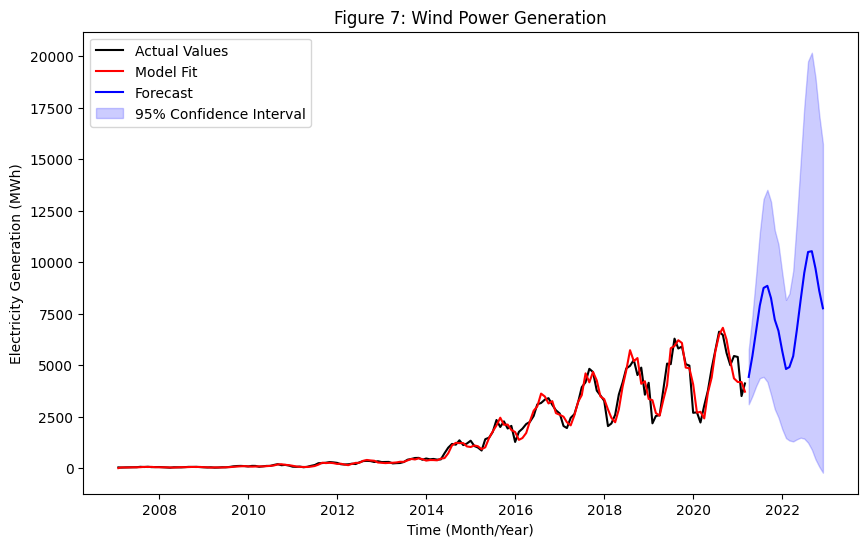

<Figure size 1000x600 with 0 Axes>

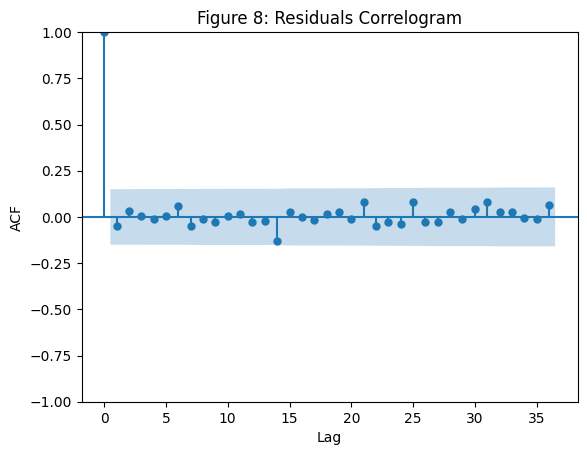

In [325]:
# Fit the chosen SARIMA model
arima_order = (8, 1, 4)
seasonal_order = (1, 0, 2, 12)
model = SARIMAX(df['generation_value_boxcox'], order=arima_order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecasting
steps = 21  # Number of steps for forecasting
predictions_future = model_fit.forecast(steps=steps)
predictions_future_inv = inv_boxcox(predictions_future, fitted_lambda)
df_inv = inv_boxcox(df['generation_value_boxcox'], fitted_lambda)

# Obtain forecasts with confidence intervals
forecast_results = model_fit.get_forecast(steps=steps)
conf_int = forecast_results.conf_int(alpha=0.05)

# Convert the lower and upper bounds back from Box-Cox
conf_int_inv = inv_boxcox(conf_int, fitted_lambda)

# Calculating standard deviations
std_errors = (conf_int_inv.iloc[:, 1] - conf_int_inv.iloc[:, 0]) / (2 * 1.96)

# Generate dates for the forecast period from 2024-08 to 2025-12
last_date = df.index[-1]
dates_forecast = pd.date_range(start=last_date, periods=steps+1, freq='M')[1:]

# Convert predictions_future_inv to DataFrame
predictions_future_inv = predictions_future_inv.to_frame(name='Forecast')

# Ensure std_errors is in a DataFrame
std_errors_df = pd.DataFrame(std_errors, index=predictions_future_inv.index, columns=['std_err'])

# Build the forecast_df DataFrame with forecasts and standard errors
forecast_df = pd.concat([predictions_future_inv, std_errors_df], axis=1)

# Calculating the 95% confidence interval
lower_bound = forecast_df['Forecast'] - 1.96 * forecast_df['std_err']
upper_bound = forecast_df['Forecast'] + 1.96 * forecast_df['std_err']

# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['generation_value'], color='black', label='Actual Values')
plt.plot(df.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Model Fit')
plt.plot(predictions_future_inv.index, predictions_future_inv, color='blue', label='Forecast')
plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()

# Correlogram of the residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=36)
plt.title('Figure 8: Residuals Correlogram')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# MLP Model

In [326]:
# Read the DataFrame from the CSV file
df = pd.read_csv('../data/month_energy_dataset.csv')

# Create a date column by combining year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter the DataFrame for the desired date range
df = df.loc['2007-01':'2021-04']

# Convert the generation values to thousands
df['generation_value'] = df['val_geracao'] / 1000

# Prepare the data for training
values_mlp = df['generation_value'].values.reshape(-1, 1)

# Use the previous 12 months to predict the next month
look_back = 12
X, y = create_dataset(values_mlp, look_back)

# Split the data into training and testing sets
train_end_index = df.index.get_loc('2020-01-01')
test_start_index = df.index.get_loc('2020-01-01')

trainX, testX = X[:train_end_index - look_back], X[train_end_index - look_back:test_start_index + len(df.loc['2020-01':'2021-03'])]
trainY, testY = y[:train_end_index - look_back], y[train_end_index - look_back:test_start_index + len(df.loc['2020-01':'2021-03'])]

In [327]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model and the set of hyperparameters to be evaluated
mlp = MLPRegressor(max_iter = 1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100), (150, 150)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Adding regularization
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh']
}

scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=scorer, cv=tscv)
grid_search.fit(trainX, trainY)

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score: {grid_search.best_score_}')

Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 150), 'solver': 'adam'}
Best score: -325.13146972298875


In [328]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = -results['mean_test_score']
results['std_test_rmse'] = results['std_test_score']

# Get the top 5 models
top5_results = results.nsmallest(5, 'mean_test_rmse')

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score (RMSE on original scale): {grid_search.best_score_}')

# Create DataFrame with top 5 models
top5_df = top5_results[['param_hidden_layer_sizes', 'param_alpha', 'param_solver', 'param_activation', 'mean_test_rmse', 'std_test_rmse']]
top5_df = top5_df.rename(columns={
    'param_hidden_layer_sizes': 'Hidden Layer Sizes',
    'param_alpha': 'Alpha',
    'param_max_iter': 'Max Iter',
    'param_solver': 'Solver',
    'param_activation': 'Activation',
    'mean_test_rmse': 'Mean Test RMSE',
    'std_test_rmse': 'Std Test RMSE'
})

# Show the top 5 models DataFrame
top5_df

Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 150), 'solver': 'adam'}
Best score (RMSE on original scale): -325.13146972298875


,Hidden Layer Sizes,Alpha,Solver,Activation,Mean Test RMSE,Std Test RMSE
4,"(150, 150)",0.0001,adam,relu,325.131470,275.203211
10,"(150, 150)",0.001,adam,relu,339.251116,288.415395
2,"(100, 100)",0.0001,adam,relu,342.009984,299.222574
22,"(150, 150)",0.1,adam,relu,342.531104,294.172138
16,"(150, 150)",0.01,adam,relu,345.545618,300.352273


In [329]:
# Train the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(trainX, trainY)

# Make predictions
trainPredict = best_mlp.predict(trainX)
testPredict = best_mlp.predict(testX)

# Inverse predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
testScore = np.sqrt(mean_squared_error(testY, testPredict))

print(f'Train RMSE: {trainScore}')
print(f'Test RMSE: {testScore}')

Train RMSE: 36.999506436542774
Test RMSE: 889.4474106854569


In [330]:
MLP_RMSE = testScore
MLP_RMSE

889.4474106854569

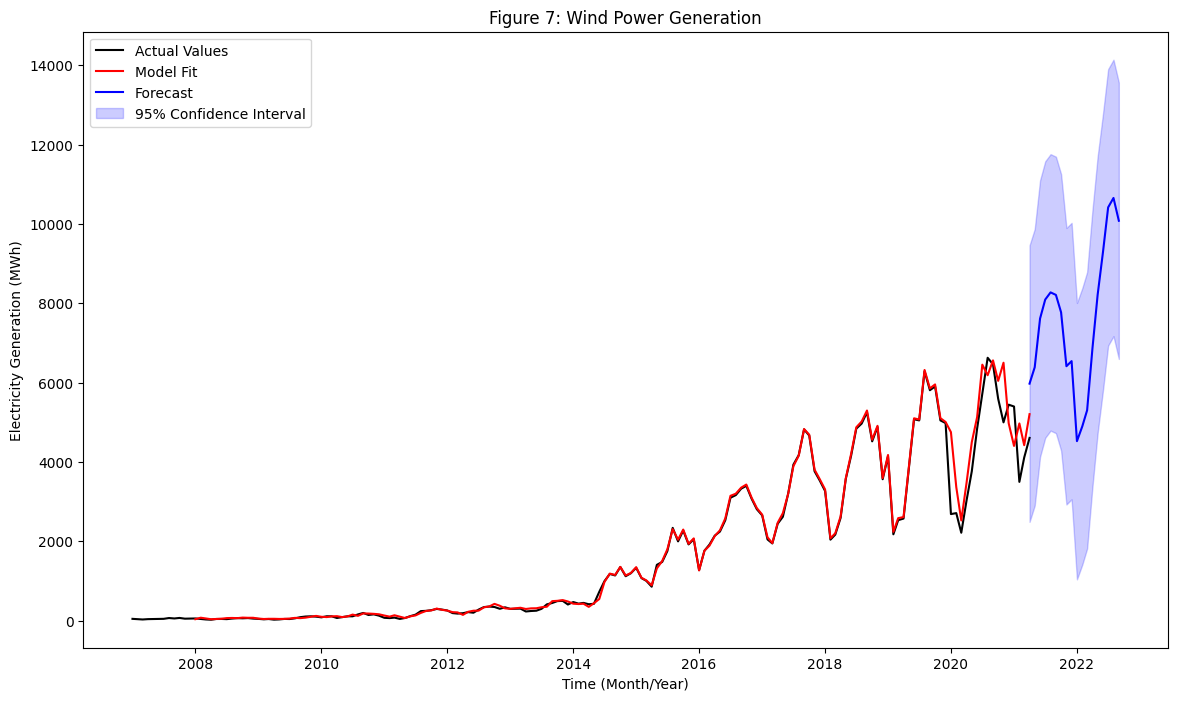

In [331]:
# Make future predictions from July 2024 to December 2025
future_steps = 18  # Number of months from July 2024 to December 2025
last_window = values_mlp[-look_back:].reshape(1, -1)

future_predictions = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions = np.array(future_predictions).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2021-04-01', periods=future_steps, freq='MS')
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['generation_value'])

# Calculate confidence intervals
prediction_intervals = []
std_future = np.std(future_predictions)
for pred in future_predictions:
    lower_bound = pred - 1.96 * std_future  # 95% confidence interval lower bound
    upper_bound = pred + 1.96 * std_future  # 95% confidence interval upper bound
    prediction_intervals.append((lower_bound[0], upper_bound[0]))

prediction_intervals = np.array(prediction_intervals)

# Combine training and test predictions to create a continuous series
all_predictions = np.empty_like(values_mlp)
all_predictions[:, :] = np.nan

# Adjust training predictions for plotting
trainPredictPlot = np.empty_like(values_mlp)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Adjust test predictions for plotting
testPredictPlot = np.empty_like(values_mlp)
testPredictPlot[:, :] = np.nan
test_start = len(trainPredictPlot) - len(testPredict)

testPredictPlot[test_start:test_start + len(testPredict), :] = testPredict

# Combine both predictions into all_predictions
all_predictions[look_back:len(trainPredict) + look_back] = trainPredict
all_predictions[test_start:test_start + len(testPredict)] = testPredict


# Plot actual values, model fit, forecast, and confidence intervals
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['generation_value'], label='Actual Values', color='black')
plt.plot(df.index[look_back:len(all_predictions)], all_predictions[look_back:], label='Model Fit', color='red')
plt.plot(future_df.index, future_predictions, label='Forecast', color='blue')
plt.fill_between(future_df.index, prediction_intervals[:, 0], prediction_intervals[:, 1], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.title('Figure 7: Wind Power Generation')
plt.legend()
plt.show()

## SARIMA MLP Model

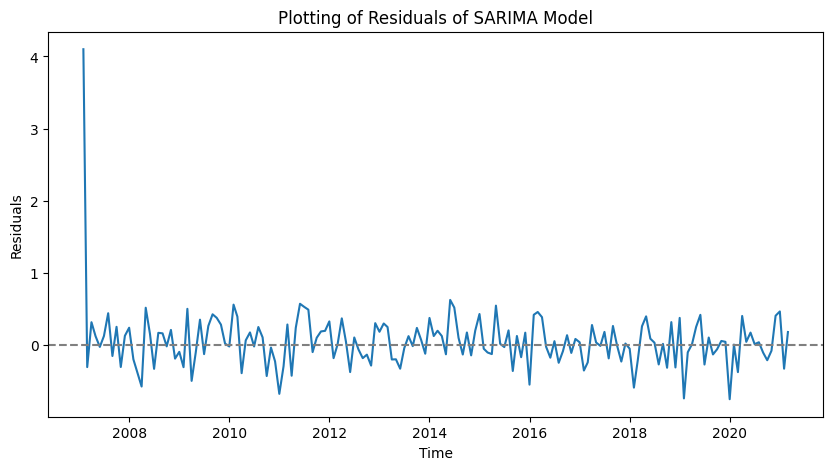

In [332]:
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Plotting of Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

In [333]:
residuals.tail(20)

date
2019-08-01    0.108641
2019-09-01   -0.125405
2019-10-01   -0.053668
2019-11-01    0.061078
2019-12-01    0.049066
2020-01-01   -0.745407
2020-02-01    0.010865
2020-03-01   -0.370203
2020-04-01    0.407131
2020-05-01    0.048963
2020-06-01    0.176883
2020-07-01    0.016863
2020-08-01    0.043280
2020-09-01   -0.099916
2020-10-01   -0.205470
2020-11-01   -0.073849
2020-12-01    0.410309
2021-01-01    0.469738
2021-02-01   -0.322749
2021-03-01    0.184989
dtype: float64

In [334]:
values = residuals.values.reshape(-1, 1)

# Use the previous 12 months to predict the next month
look_back = 12
X, y = create_dataset(values, look_back)

# Split the data into training and testing sets
train_end_index = df.index.get_loc('2019-12-01')
test_start_index = df.index.get_loc('2019-12-01')

trainX, testX = X[:train_end_index], X[train_end_index - look_back:train_end_index + len(df.loc['2019-12':'2021-04'])]
trainY, testY = y[:train_end_index], y[train_end_index - look_back:train_end_index + len(df.loc['2019-12':'2021-04'])]

In [335]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model and the set of hyperparameters to be evaluated
mlp = MLPRegressor(max_iter = 1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100), (150, 150)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Adding regularization
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh']
}

scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=scorer, cv=tscv)
grid_search.fit(trainX, trainY)

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score: {grid_search.best_score_}')

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (150, 150), 'solver': 'sgd'}
Best score: -0.28241053144347206


In [336]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = -results['mean_test_score']
results['std_test_rmse'] = results['std_test_score']

# Get the top 5 models
top5_results = results.nsmallest(5, 'mean_test_rmse')

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score (RMSE on original scale): {grid_search.best_score_}')

# Create DataFrame with top 5 models
top5_df = top5_results[['param_hidden_layer_sizes', 'param_alpha', 'param_solver', 'param_activation', 'mean_test_rmse', 'std_test_rmse']]
top5_df = top5_df.rename(columns={
    'param_hidden_layer_sizes': 'Hidden Layer Sizes',
    'param_alpha': 'Alpha',
    'param_max_iter': 'Max Iter',
    'param_solver': 'Solver',
    'param_activation': 'Activation',
    'mean_test_rmse': 'Mean Test RMSE',
    'std_test_rmse': 'Std Test RMSE'
})

# Show the top 5 models DataFrame
top5_df

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (150, 150), 'solver': 'sgd'}
Best score (RMSE on original scale): -0.28241053144347206


,Hidden Layer Sizes,Alpha,Solver,Activation,Mean Test RMSE,Std Test RMSE
23,"(150, 150)",0.1,sgd,relu,0.282411,0.031623
17,"(150, 150)",0.01,sgd,relu,0.282541,0.031737
11,"(150, 150)",0.001,sgd,relu,0.282544,0.031739
5,"(150, 150)",0.0001,sgd,relu,0.282544,0.031740
21,"(100, 100)",0.1,sgd,relu,0.291211,0.042656


In [337]:
# Train the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(trainX, trainY)

# Make predictions
trainPredict = best_mlp.predict(trainX)
testPredict = best_mlp.predict(testX)

# Inverse predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

In [338]:
index_dates = pd.date_range(start='2020-01-01', periods=len(testPredict), freq='MS') 

In [339]:
testPredict_df = pd.DataFrame(testPredict, columns=['Predictions'], index=index_dates)

In [340]:
predictions_inv_df = pd.DataFrame(predictions_inv)

predictions_inv_df

,predicted_mean
2020-01-01,4145.328923
2020-02-01,3266.278150
2020-03-01,3448.512458
2020-04-01,3364.772654
2020-05-01,4377.679041
2020-06-01,4959.782048
2020-07-01,5899.951344
2020-08-01,6559.111058
2020-09-01,6689.479439
2020-10-01,6507.040908


In [341]:
testPredict_df

,Predictions
2020-01-01,-0.047138
2020-02-01,0.026402
2020-03-01,-0.030036
2020-04-01,-0.030900
2020-05-01,-0.043837
2020-06-01,-0.008970
2020-07-01,-0.077679
2020-08-01,-0.032329
2020-09-01,0.040344
2020-10-01,0.096450


In [350]:
start_weight = 1000
end_weight = 5000
step = 1

best_rmse = np.inf 
best_weight = None

# Loop for possible weights
for weight in np.arange(start_weight, end_weight + step, step):
    # Calculate combined predictions
    combined_predictions = predictions_inv_df['predicted_mean'] + weight * testPredict_df['Predictions']

    # Calculate RMSE
    current_rmse = rmse_scorer(test['generation_value'], combined_predictions)

    # Verify best weight
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_weight = weight

SARIMA_MLP_RMSE = best_rmse

print(f"Best Weight: {best_weight}")
print(f"Best RMSE: {best_rmse}")

Best Weight: 1227
Best RMSE: 710.6895073021891


In [343]:
predictions_future_inv

,Forecast
2021-04-01,4429.016901
2021-05-01,5435.681366
2021-06-01,6676.409790
2021-07-01,7893.894499
2021-08-01,8748.421636
2021-09-01,8851.486727
2021-10-01,8253.907522
2021-11-01,7204.154330
2021-12-01,6668.145417
2022-01-01,5688.519563


In [347]:
# Make future predictions from July 2024 to December 2025
future_steps = 21  # Number of months from July 2024 to December 2025
last_window = values[-look_back:].reshape(1, -1)

future_predictions_resid = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions_resid.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions_resid = np.array(future_predictions_resid).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2021-04-01', periods=future_steps, freq='MS')
future_df_resid = pd.DataFrame(data=future_predictions_resid, index=future_dates, columns=['generation_value'])

future_df_resid

,generation_value
2021-04-01,-0.019508
2021-05-01,-0.007926
2021-06-01,0.021412
2021-07-01,0.152266
2021-08-01,-0.005438
2021-09-01,-0.058204
2021-10-01,0.018019
2021-11-01,0.043475
2021-12-01,-0.083836
2022-01-01,-0.057391


In [348]:
combined_predictions = predictions_future_inv['Forecast'] + best_weight * future_df_resid['generation_value']

combined_predictions

2021-04-01     4405.080321
2021-05-01     5425.955953
2021-06-01     6702.682021
2021-07-01     8080.724870
2021-08-01     8741.749017
2021-09-01     8780.070943
2021-10-01     8276.016927
2021-11-01     7257.498148
2021-12-01     6565.278232
2022-01-01     5618.100718
2022-02-01     4887.388290
2022-03-01     4852.398442
2022-04-01     5382.789010
2022-05-01     6703.725433
2022-06-01     8153.101326
2022-07-01     9405.115580
2022-08-01    10468.189580
2022-09-01    10545.510283
2022-10-01     9668.945783
2022-11-01     8550.109729
2022-12-01     7760.277586
Freq: MS, dtype: float64

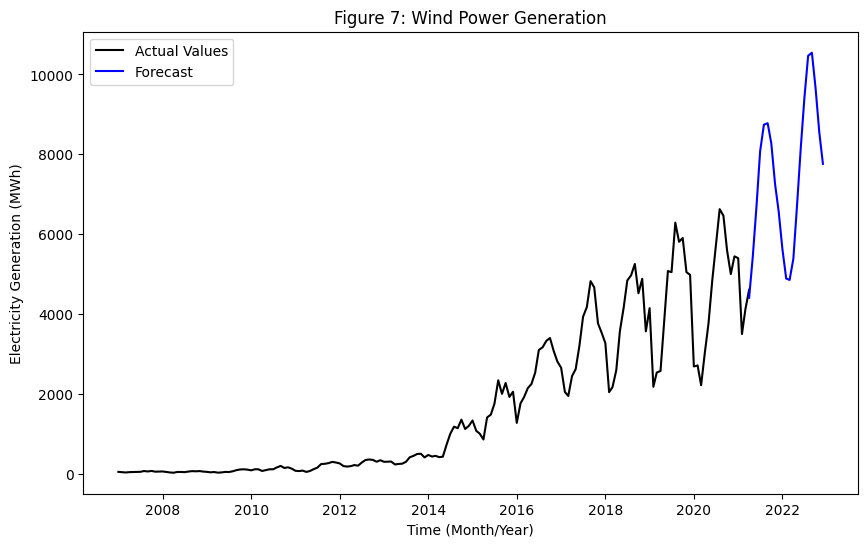

In [349]:
# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['generation_value'], color='black', label='Actual Values')
#plt.plot(df.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Model Fit')
plt.plot(combined_predictions.index, combined_predictions, color='blue', label='Forecast')
#plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()

In [364]:
data = {
    "Model": ["SARIMA-ARTICLE", "SARIMA-MLP"],
    "RMSE": [SARIMA_RMSE_ARTICLE, SARIMA_MLP_RMSE]
}

rmse_df = pd.DataFrame(data)
rmse_df

,Model,RMSE
0,SARIMA-ARTICLE,773.790000
1,SARIMA-MLP,710.689507
